# Work Description

In the previous notebook AutoMPG_EDA, we introduced the dataset AutoMPG, described its content and analysed the different relationships between our target variable 'MPG' and the other discret and continuous variables present in the dataset. Now, we will proceed to construct, assess, and tune various regression models using the scikit-learn packages. This notebook "AutoMPG_Comparing_ML_Models", details this phase where we aim to identify the most suitable model for our prediction task.

To systematically compare different machine learning algorithms, scaling methods, and evaluation metrics for our regression problem, we structured our experiments by following these steps:
1. Prepare our Data

 * Load the Data, clean it, encode the features
 * Choose different feature Scaling methods to be applied:

2. Define a baseline model and evaluate it.

  * We will train a Linear Regression model as our baseline
  * We will evaluate its performances accross different scaling methods and using cross validation

3. Set Up the Experiment and evaluate the results

     * Choose a set of machine learning algorithms to compare, such as LinearRegression, RidgeRegression, LassoRegression, RandomForest, GradientBoosting, SupportVectorRegression, K-Nearest-Neighbors, DecisionTree, and XGBoost.
     * Create a function that accepts the list of models, scaling methods, and the datasets, and performs the fitting and evaluation.
     * Use evaluation metrics such as R2, MAE, MSE, and MAPE to compare model performance.
     * Collect the results of each experiment, index them by model and scaling method, and store them in a structured format for comparison.
     * Analyse the results and draw conclusions
4. Perform Cross-validation and inscpect the overfitting problem

  * Conduct a cross-validation and compute the performances
  * Check relative difference between training and testing sets
  * Overall Conclusions

5. Perform Hyperparameter Tuning and access the results
    * Include hyperparameter tuning within our experiment to find the best parameters for each model.
    * Evaluate the new models and compare their results
    * Inscpect the overfitting problem
    * Overall conclusions
    * Select the best performing model


   




In [115]:
from __future__ import absolute_import, print_function, division
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.utils import shuffle
import joblib #for model saving

sns.set_theme(style="whitegrid", palette="Set2")

%matplotlib inline

# Task 1:  Preparing the data for the training

### 2.1: Loading the data

In [3]:
dataset_path= 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


In [4]:
dataset_raw= pd.read_csv(dataset_path, names=column_names, na_values='?', comment= "\t", sep=" ", skipinitialspace=True )

In [5]:
dataset_raw.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
dataset_raw.shape

(398, 8)

In [7]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


### 1.2 Cleaning the data

In our previous notebook (AutoMPG_EDA), We have analysed the missing data and explained why we should drop them from the dataset.

In [8]:
dataset_raw.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
df= dataset_raw.copy()

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(392, 8)

### 1.3 Encoding the data

The 'Origin' feature is a categorical variable representing the country of origin for each car. In this dataset, the code '1' corresponds to the USA, '2' to Europe, and '3' to Japan. These values are nominal and do not imply any order or ranking. To appropriately handle this feature in our machine learning model, we will apply one-hot encoding, which converts each category into a separate binary column, ensuring that the model does not assume any ordinal relationship among the categories.

In the other hand, the orther 'ordinal variables' like "Model Year" and "Cylinders" have a meaningful order and magnitude, which means that their values represent a ranking or progression that should be preserved in the encoding process. The one-hot encoding of these variables might not be suitable treats each category as independent, which can lead to a loss of the ordinal information. For example, the progression from 4 to 6 to 8 cylinders is lost when these values are converted into separate binary columns.







In [12]:
#coding the Origin.
origin = df.pop('Origin')

In [13]:
df['USA'] = (origin==1) * 1
df['Europe']= (origin==2) * 1
df['Japan']= (origin==3) * 1
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   USA           392 non-null    int64  
 8   Europe        392 non-null    int64  
 9   Japan         392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 33.7 KB


In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0


### 1.4 Scaling the data

We can notice from the previous table that our features have different ranges. Often, if we use them without scaling, the features with large absolute values will dominate the prediction outcome. Instead, to give each feature a fair opportunity to contribute to the prediction outcome, we must bring all features on the same scale. The two most common scaling techniques are:

- **Normalization**: This scaling technique restricts the feature values between 0 and 1. To apply normalization, we subtract the minimum feature value and divide it by the range (difference between min and max) of that feature. Normalization may not be a good technique if some of our features have a sharp skew or have a few extreme outliers.
- **Standardization**: This technique transforms the feature data distribution to the standard normal distribution. We can implement this technique by subtracting the mean and dividing it by the standard deviation. This technique is generally preferred if the feature has a sharp skew or a few extreme outliers.

In our previous analysis, we did not notice the presence of extreme outliers or significant skewness in any of our features. Most of them follow a Gaussian distribution with moderate skewness. However, this is not sufficient to determine the most suitable scaling method for our dataset. Therefore, we will compare the performance of our baseline model (Logistic Regression) under the following scenarios:

- Training the baseline model without scaling
- Training the baseline model with normalization as the scaling method
- Training the baseline model with standardization as the scaling method
- Comparing and choosing the best scaling method

In this notebook, we will use the sklearn pipeline to conduct our experiments. This approach is faster and more concise for experimenting with different training pipelines. Scaling will be defined as one step in these pipelines.

In this notebook, we will be using sklearn pipline to conduct our different experimentations. It is faster and more conscise way to experiment different training pipelines. Scaling will defined as one step of these pipelines.

### 1.5 Splitting the data into training and the testing sets

In [16]:
#Seperating Input and ouput variable
y = df['MPG']
X= df.drop('MPG', axis=1)
#Shuffeling the data
X, y = shuffle(X, y, random_state=42)

In [17]:
#Splitting the data into training and testing data
X_train, X_test, Y_train, Y_test= train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(313, 9)
(313,)
(79, 9)
(79,)


# Task 2: Training baseline Model with Linear Regression and compare scaling methods



### 2.1 Training LR Model without data scaling

In [18]:
#Fitting the LR model to our training data
lr=LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [19]:
#A function to evaluate the results of the  model on the testing set
def evaluating_model(model, model_name,X_train, Y_train, X_test, y_test) :
  results = {}
  train_score = model.score(X_train, Y_train)
  test_score = model.score(X_test, Y_test)
  Y_pred = model.predict(X_test)
  mse= mean_squared_error(Y_test, Y_pred)
  mae= mean_absolute_error(Y_test, Y_pred)
  mape= mean_absolute_percentage_error(Y_test, Y_pred)

  results = {
          'model_name' : model_name,
          'r2-training' : train_score,
          'r2-testing' : test_score,
          'mae' : mae,
          'mse' : mse ,
          'mape' : mape,
  }
  return Y_pred, results


In [20]:
#A function to Plot the predictions of the Testing set
def plotting_prediction (y_test, y_pred) :
  a = plt.axes(aspect='equal')
  plt.scatter(y_test, y_pred)
  plt.xlabel('True Values [MPG]')
  plt.ylabel('Predictions [MPG]')
  lims = [0, 50]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

In [21]:
#Evaluating the LR baseline model
Y_pred, results = evaluating_model(lr, "LinearRegression_NoScaling", X_train, Y_train, X_test, Y_test)
print("## Evaluation of the LinearRegression_NoScaling  Model \n" )
print(f" -Training score (R-2): {results['r2-training']:.3f}")
print(f" -Testing score (R-2): {results['r2-testing']:.3f}")
print(f" -Testing set Mean Absolute Error : {results['mae']:.3f} MPG")
print(f" -Testing set Mean Square Error : {results['mse']:.3f}")
print(f" -Testing set Mean Absolute Percentage Error : {results['mape']:.3f}")

## Evaluation of the LinearRegression_NoScaling  Model 

 -Training score (R-2): 0.820
 -Testing score (R-2): 0.839
 -Testing set Mean Absolute Error : 2.110 MPG
 -Testing set Mean Square Error : 8.166
 -Testing set Mean Absolute Percentage Error : 0.100


**Plotting the predictions**

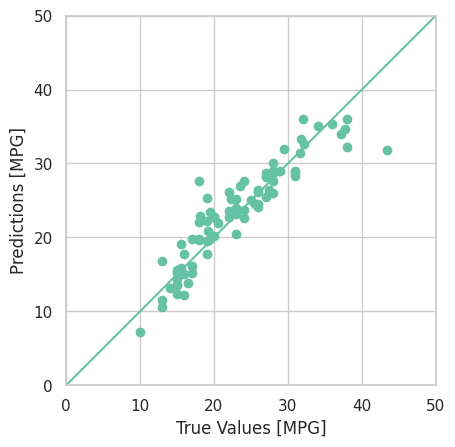

In [22]:
plotting_prediction(Y_test, Y_pred)

### 2.2 Training baseline model with different data scaling methods

We will be comparing 2 different scaling methods often used in the litterature : Normalizer and StandardScaler. To ease the data preprocessing and model evalution, we will be creating a training pipeline using sklearn.

In [23]:
#A generic function to create a training pipeline based of the estimator and the scaling method passed as params
def train_model_scaler(estimator , scalar, X_train, Y_train) :
  pipeline = Pipeline(steps=[
      ('scaler', scalar),
      ('model', estimator)
  ])
  # Training the model
  pipeline.fit(X_train, Y_train)

  return pipeline

In [24]:
#Creating and evaluation the baseline model with the Normlizer method as a scaler
lr_normalizer = train_model_scaler( LinearRegression(), Normalizer(), X_train, Y_train)
Y_pred_norm, results = evaluating_model(lr_normalizer, "LinearRegression_Normalizer", X_train, Y_train, X_test, Y_test)
print("## Evaluation of the LinearRegression_Normalizer  Model \n" )
print(f" -Training score (R-2): {results['r2-training']:.3f}")
print(f" -Testing score (R-2): {results['r2-testing']:.3f}")
print(f" -Testing set Mean Absolute Error : {results['mae']:.3f} MPG")
print(f" -Testing set Mean Square Error : {results['mse']:.3f}")
print(f" -Testing set Mean Absolute Percentage Error : {results['mape']:.3f}")



## Evaluation of the LinearRegression_Normalizer  Model 

 -Training score (R-2): 0.861
 -Testing score (R-2): 0.872
 -Testing set Mean Absolute Error : 1.807 MPG
 -Testing set Mean Square Error : 6.519
 -Testing set Mean Absolute Percentage Error : 0.080


In [25]:
#Creating and evaluation the baseline model with the StandardScaler method as a scaler
lr_standard = train_model_scaler( LinearRegression(), StandardScaler(), X_train, Y_train)
Y_pred_standard, results = evaluating_model(lr_standard, "LinearRegression_Standard", X_train, Y_train, X_test, Y_test)
print("## Evaluation of the LinearRegression_Standard  Model \n" )
print(f" -Training score (R-2): {results['r2-training']:.3f}")
print(f" -Testing score (R-2): {results['r2-testing']:.3f}")
print(f" -Testing set Mean Absolute Error : {results['mae']:.3f} MPG")
print(f" -Testing set Mean Square Error : {results['mse']:.3f}")
print(f" -Testing set Mean Absolute Percentage Error : {results['mape']:.3f}")

## Evaluation of the LinearRegression_Standard  Model 

 -Training score (R-2): 0.820
 -Testing score (R-2): 0.839
 -Testing set Mean Absolute Error : 2.110 MPG
 -Testing set Mean Square Error : 8.166
 -Testing set Mean Absolute Percentage Error : 0.100


**Observations** : Based on the evaluation results we obtained from comparing the two preprocessing methods (Normalizer and StandardScaler) with a Linear Regression model on my AutoMPG dataset, it appears that using the Normalizer yields better performance metrics than the StandardScaler and this is according to the 4 metrics we used. The superior performance of the Normalizer pipeline suggests that for this particular dataset and model, scaling each sample to unit norm is more effective than standardizing features to zero mean and unit variance. These empirical resultats are in contrast with  the fact that StandardScaler is more recommanded to use with linear models. The obtained resultats could be due to several reasons, mainly related to the nature of the data, their particular distributions and the relationships between the features.


### 2.3 Validating the evaluations results using cross validation

The scoring metrics in cross_validate are defined with their negative counterparts (neg_mean_absolute_error, neg_mean_squared_error, and neg_mean_absolute_percentage_error) because scikit-learn's cross_validate function expects scorers to be maximized. Negative values ensure that lower errors are better, consistent with the convention that higher scores are better.

In [26]:
# Custom scoring dictionary
scoring = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# Function to evaluate model using cross-validation and return the mean scores
def cross_val_evaluate_model(estimator , scalar, X, y, scoring, cv=5):
  pipeline = Pipeline(steps=[
    ('scaler', scalar),
    ('model', estimator)
  ])
  scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, return_train_score=False)
  mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}
  return mean_scores

# Evaluate both models with cross-validation
results_normalizer = cross_val_evaluate_model(LinearRegression(), Normalizer() , X, y, scoring, cv=5)
results_standard = cross_val_evaluate_model(LinearRegression(), StandardScaler(), X, y, scoring, cv=5)

print('Cross-Validation Results with Normalizer: \n ', results_normalizer)
print('Cross-Validation Results with StandardScaler: \n ', results_standard)

Cross-Validation Results with Normalizer: 
  {'R2': 0.8513022527642958, 'MAE': -2.152866730912974, 'MSE': -8.942541655851775, 'MAPE': -0.0934186576355752}
Cross-Validation Results with StandardScaler: 
  {'R2': 0.8132509152648305, 'MAE': -2.5752507768342925, 'MSE': -11.304785135551196, 'MAPE': -0.12002314427228575}


**Conclusion:**

Based on the cross-validation results, it could be noticed that the linear Regression model with the Normalizer method demonstrates better predictive accuracy and lower error rates. Consequently, for the given Auto MPG dataset and Linear Regression model, using the Normalizer as the data scaling method is the more effective choice.

# Task 3: Comparing different training models across different scaling methods

In this section is to compare our baseline model to other well knowing machine learning models that are often used to solve regression problems. Our goal is to select the most performing models and suggest improvements if any problem is detected. To achieve this goal, we selected a set of candidate regressors to be compared according to a set of evaluation metrics. We will also examine their performances accross the two scaling methods : normalization and standardization that we have analysed in the above sections.

#### Key Metrics we will be using:

MAE: Measures the average magnitude of errors in a set of predictions, without considering their direction. It gives a linear score which means all individual differences are equally weighted.
MAPE: Measures the average magnitude of errors as a percentage. It's useful for understanding the error relative to the actual values.
MSE: Measures the average of the squares of the errors. It gives more weight to larger errors, which can be useful for models where large errors are particularly undesirable.
R²: Measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It provides an indication of the goodness of fit of the model.

- **R² (R-Squared)**: Indicates the proportion of variance in the dependent variable that is predictable from the independent variables. Higher values (closer to 1) are better. It provides an indication of the goodness of fit of the model, but can sometimes be misleading if not interpreted with other metrics.
- **MAE (Mean Absolute Error)**: The average absolute difference between predicted and actual values. Lower values are better. MAE doesn't consider their direction. It gives a linear score which means all individual differences are equally weighted. Less sensitive to outliers compared to MSE, as it doesn't square the errors. Directly interpretable in the same units as the original data, making it easy to understand.
- **MSE (Mean Squared Error)**: The average of the squared differences between predicted and actual values. Lower values are better. MSE measures the average of the squares of the errors. It gives more weight to larger errors, which can be useful for models where large errors are particularly undesirable. It's more sensitive to outliers because errors are squared.
- **MAPE (Mean Absolute Percentage Error)**: The average absolute percentage error between predicted and actual values. Lower values are better. It measures the average magnitude of errors as a percentage. It's useful for understanding the error relative to the actual values. It is less sensitive to outliers, but can be problematic with very small actual values. Since it expresses error as a percentage, MAPE can be more intuitive for some applications.


#### Machine learning regressors to be evaluated :

Here are a short description of each selected ML algorithm for our evaluation. I tried to highlight their most distinctive features:

- **LinearRegression**: A basic linear model that assumes a linear relationship between the input features and the target variable.

- **RidgeRegression**: A linear model that includes an L2 regularization term to penalize large coefficients, reducing overfitting.

- **LassoRegression**: Similar to Ridge Regression but uses L1 regularization, which can shrink some coefficients to zero, effectively performing feature selection.

- **RandomForest**: An ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and control overfitting.

- **GradientBoosting**: An ensemble technique that builds trees sequentially, with each tree trying to correct the errors of the previous one, leading to a strong predictive model.

- **SupportVectorRegression**: Uses support vector machines to perform regression, finding a hyperplane that best fits the data while maximizing the margin.

- **K-Nearest-Neighbors**: A non-parametric method that predicts the target by averaging the outputs of the k-nearest data points in the feature space.

- **DecisionTree**: A model that splits the data into subsets based on feature values, creating a tree-like structure where each leaf represents a predicted outcome.

- **XGBoost**: An optimized implementation of gradient boosting that is highly efficient and effective, known for its speed and performance in competitions.

### 3.1 Training different ML models and evaluating their performances with default hyperparameters

We have written a function that takes a list of ML regressors and the training and testing datasets. For each regressor in the list, the function fits it to the data, then computes a set of evaluation metrics on both the training and testing sets. These metrics are gathered, indexed by the regressor name, and returned by the function.


The models were left with their default parameters for simplicity, but in a comprehensive experiment, tuning multiple hyperparameters for each model is important for achieving the best results. It's important to outline that we choice to set 'max_iter' for Lasso was to ensure the solver has enough iterations to converge, especially since Lasso can be sensitive to convergence issues with its L1 regularization. We also set its 'alpha' parameter to '0.5'

In [27]:
#Function to train and compare a list of ML algorithms passed as argument
def train_evaluate_models(selected_models, X_train, X_test, Y_train, Y_test) :
  all_results=[]

  for model_name, model in  selected_models.items() :
    # Training the model
    model.fit(X_train, Y_train)

    # Evaluating the model
    _ , results = evaluating_model(model, model_name, X_train, Y_train, X_test, Y_test)
    all_results.append(results)

  return all_results

In [28]:
#train the selected regressors across the different selected scaling methods
def scale_train_evaluate_models(selected_models, scalers,  X_train, X_test, Y_train, Y_test) :
  #DF To store all results
  full_evals=pd.DataFrame()

  for scaler_name, scaler in scalers.items() :
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    #Call the training function and convert the output to a dataframe
    df_all_results = pd.DataFrame(train_evaluate_models(selected_models, X_train_sc, X_test_sc, Y_train, Y_test))
    #Add the scaler method name
    df_all_results['scaler'] = scaler_name
    #Concat to the previous exp. results
    full_evals= pd.concat([full_evals,df_all_results], ignore_index=True)

  return full_evals

In [29]:
#The scaling methods we will study
scalers = {
    'StandardScaler': StandardScaler(),
    'Normalizer': Normalizer(),
}

# List of supported model, defined using default parameters
selected_models = {
        "LinearRegression": LinearRegression(),
        "RidgeRegression": Ridge(),
        "LassoRegression": Lasso(max_iter=10000, alpha=0.5) ,
        "RandomForest": RandomForestRegressor(random_state=42),
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
        "SupportVectorRegression": SVR(),
        "K-Nearest-Neighbors": KNeighborsRegressor(),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(seed=42)
}

In [30]:
#Full experimentation
full_evals = scale_train_evaluate_models(selected_models, scalers, X_train, X_test, Y_train, Y_test)
full_evals

,model_name,r2-training,r2-testing,mae,mse,mape,scaler
0,LinearRegression,0.820247,0.839161,2.110497,8.165998,0.099695,StandardScaler
1,RidgeRegression,0.820148,0.838360,2.105197,8.206669,0.099215,StandardScaler
2,LassoRegression,0.808375,0.831652,2.067544,8.547271,0.092905,StandardScaler
3,RandomForest,0.982262,0.888621,1.625570,5.654856,0.071608,StandardScaler
4,GradientBoosting,0.970323,0.904219,1.663248,4.862923,0.074480,StandardScaler
5,SupportVectorRegression,0.834858,0.848838,1.869078,7.674707,0.081425,StandardScaler
6,K-Nearest-Neighbors,0.900376,0.885953,1.840253,5.790314,0.079395,StandardScaler
7,DecisionTree,1.000000,0.811630,2.237975,9.563797,0.098873,StandardScaler
8,XGBoost,0.999988,0.857141,1.822575,7.253125,0.078411,StandardScaler
9,LinearRegression,0.861430,0.871593,1.806734,6.519373,0.079625,Normalizer


At first glance, we can notice that LassoRegression model associated to the Normalization method didn't successed to converge. In fact, its R2 value is equal to 0 on the training set and -0.01 on the testing set. The Lasso performances improved when switching to data scaled using StandardScaler method. It's obvious that normalization is not the appropriate scaling method when working with the Lasso Regression Model. We can also notice a perfect R2 equal to 1 performed by DecisionTree on the training set with a drop of this metric value on the test set. This suggests an overfitting problem. Decision Tree is not the only model showing signs of overfitting. We will inspect these signs with further attention in a dedicated sub-section in this notebook.

In [31]:
full_evals.sort_values('r2-testing', ascending=False, inplace=True) #Higher values, better performances
full_evals

,model_name,r2-training,r2-testing,mae,mse,mape,scaler
4,GradientBoosting,0.970323,0.904219,1.663248,4.862923,0.074480,StandardScaler
3,RandomForest,0.982262,0.888621,1.625570,5.654856,0.071608,StandardScaler
6,K-Nearest-Neighbors,0.900376,0.885953,1.840253,5.790314,0.079395,StandardScaler
9,LinearRegression,0.861430,0.871593,1.806734,6.519373,0.079625,Normalizer
13,GradientBoosting,0.971613,0.866936,1.826331,6.755843,0.080393,Normalizer
8,XGBoost,0.999988,0.857141,1.822575,7.253125,0.078411,StandardScaler
5,SupportVectorRegression,0.834858,0.848838,1.869078,7.674707,0.081425,StandardScaler
0,LinearRegression,0.820247,0.839161,2.110497,8.165998,0.099695,StandardScaler
1,RidgeRegression,0.820148,0.838360,2.105197,8.206669,0.099215,StandardScaler
2,LassoRegression,0.808375,0.831652,2.067544,8.547271,0.092905,StandardScaler


From the table above, after sorting the results by the R-squared value on the testing data, we observe that the best performances are associated with the use of StandardScaler. The top three best-performing models are Gradient Boosting, Random Forest, and K-Nearest Neighbors (KNN), all of which achieved their highest R-squared values with standardized data. Following these, Linear Regression, our baseline model, achieved its best performance with normalized data. These evaluations will be further illustrated and analyzed in the next section using various plotting techniques.

### 3.2 Visualization of the results

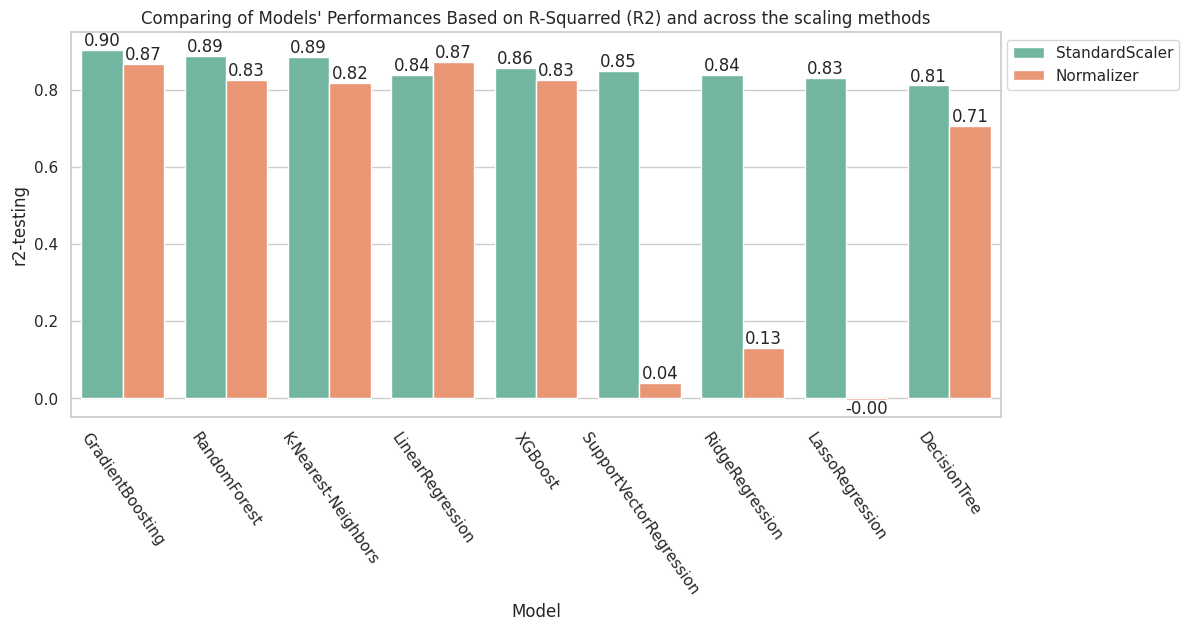

In [32]:
#Sorting the data according R2 on testing data
full_evals.sort_values(['r2-testing','scaler'], ascending=False, inplace=True)

#Plotting the R-2 performances for each model and scaling method
plt.figure(figsize=(12,5))
bar=sns.barplot(data=full_evals, x='model_name', y='r2-testing', hue='scaler')
plt.xlabel("Model")
plt.title("Comparing of Models' Performances Based on R-Squarred (R2) and across the scaling methods")
plt.xticks(rotation = -55)
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.2f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)
#bar.plot('SupportVectorRegression', 0.901459, '*', color='r', markersize=10 )
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


This plot reinforces our earlier observations that using the StandardScaler has improved the performance of all machine learning models, except for our baseline model, Linear Regression. Specifically, the R² score for Linear Regression decreased with StandardScaler. Conversely, the Lasso model failed to converge with the normalized dataset but exhibited a competitive R² value with standardized data. This behavior is further illustrated in the following plots, which compare model performance using different error metrics such as MAPE, MAE, and MSE across different scaling methods. Overall, our baseline model ranked fourth with a highly competitive R² on the testing set. Hence, we have identified three better-performing models: Gradient Boosting, Random Forest, and KNN, which are promising candidates for our learning task. However, we should first inspect their performance according to other metrics and evaluate how well they can generalize to unseen data.

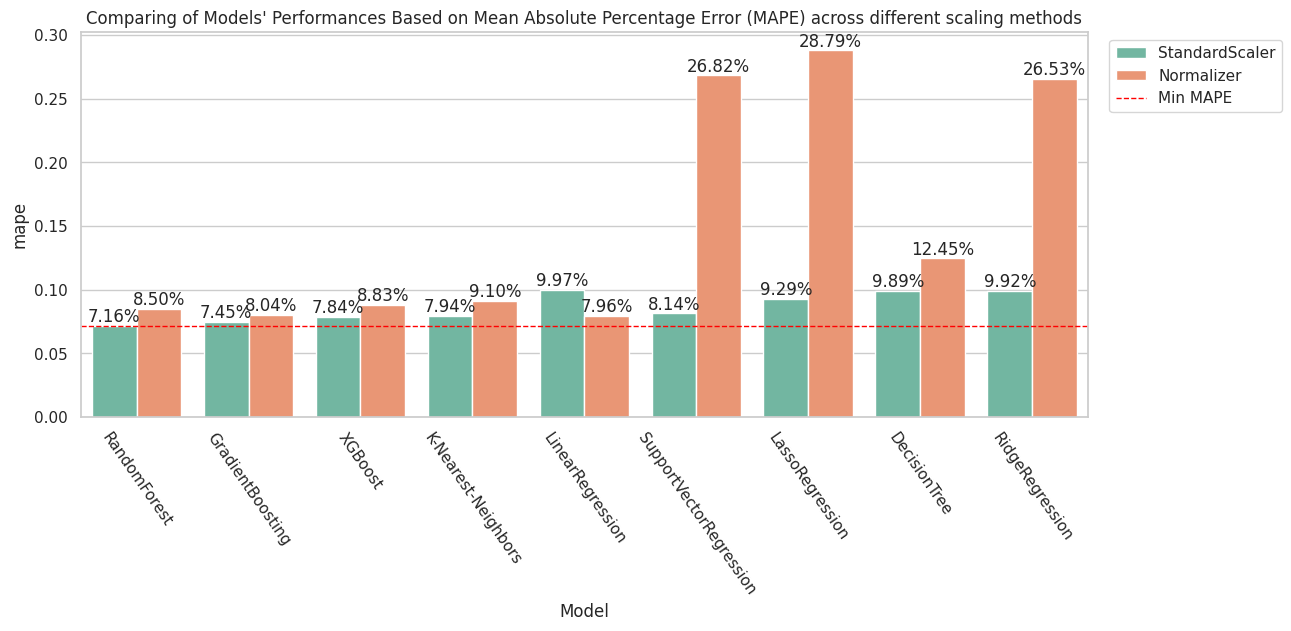

In [86]:
full_evals.sort_values(['mape','scaler'], inplace=True)
plt.figure(figsize=(13,5))
bar=sns.barplot(data=full_evals, x='model_name', y='mape', hue='scaler')
plt.xlabel("Model")
plt.title("Comparing of Models' Performances Based on Mean Absolute Percentage Error (MAPE) across different scaling methods")
for container in bar.containers:
  values = container.datavalues*100
  labels = ["{:.2f}%".format(val) for val in values]
  bar.bar_label(container, labels=labels)
plt.axhline(full_evals.mape.min(), color='r',linestyle='dashed',linewidth=1, label="Min MAPE")
plt.xticks(rotation = -55)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

The red line in the upper plot marks the minimum observed value of MAPE accross the models. XGboost has showed the lowest MAPE with 7.73% suggesting that its predictions are more accurate than other models

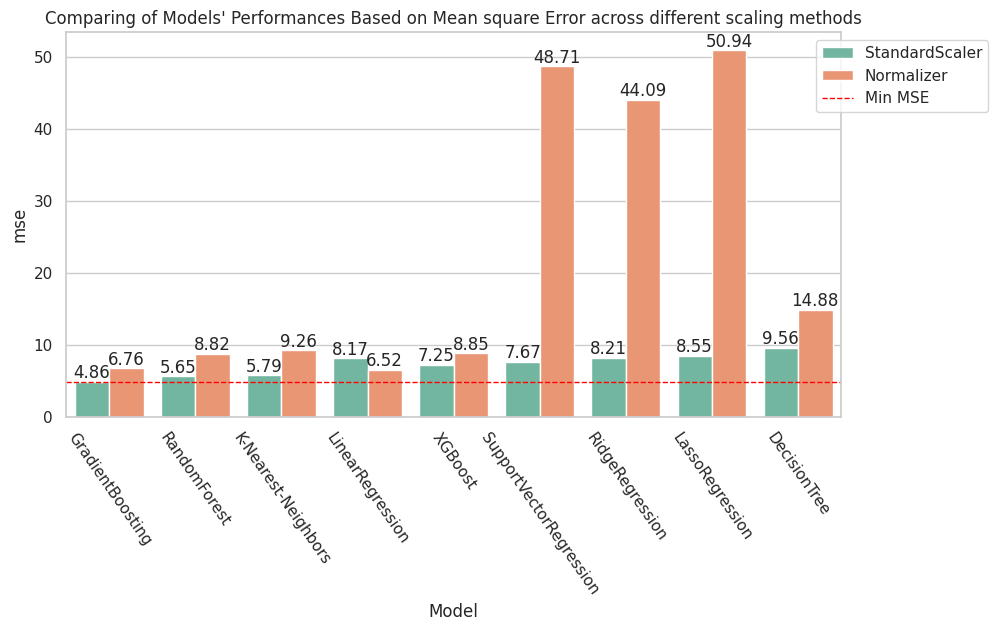

In [85]:
full_evals.sort_values(['mse','scaler'], inplace=True)
plt.figure(figsize=(10,5))
bar=sns.barplot(data=full_evals, x='model_name', y='mse', hue='scaler')
plt.xlabel("Model")
plt.title("Comparing of Models' Performances Based on Mean square Error across different scaling methods")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.2f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)
plt.axhline(full_evals.mse.min(), color='r',linestyle='dashed',linewidth=1, label="Min MSE")
plt.xticks(rotation = -55)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

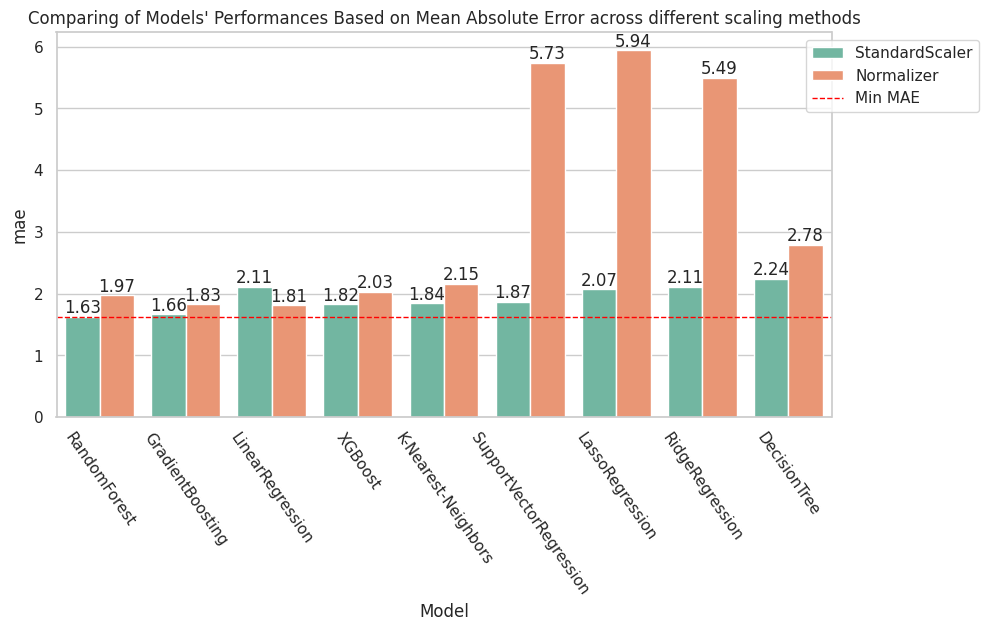

In [84]:
full_evals.sort_values(['mae','scaler'], inplace=True)
plt.figure(figsize=(10,5))
bar=sns.barplot(data=full_evals, x='model_name', y='mae', hue='scaler')
plt.xlabel("Model")
plt.title("Comparing of Models' Performances Based on Mean Absolute Error across different scaling methods")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.2f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)
plt.axhline(full_evals.mae.min(), color='r',linestyle='dashed',linewidth=1, label="Min MAE")
plt.xticks(rotation = -55)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

### 3.3  Analysis of model evaluation results

##### Recommended Scaling Method

From the previous table and plots, it is evident that the **StandardScaler** consistently provides better performance across a variety of models compared to the **Normalizer**. The top-performing models, including Gradient Boosting, Random Forest, and K-Nearest Neighbors, all achieve their best results with the StandardScaler. Therefore, we recommend using the StandardScaler for scaling the data in this task.

##### Performance Classification of Models

1. **Top Performers:**
   - **Gradient Boosting:** Exhibits the best R² and MSE, indicating it captures the variance in the data well and has smaller squared errors overall.Ranks behind RandomForest in terms of MAE and MAPE, suggesting that while it may handle outliers better (hence lower MSE), its average absolute error and relative error percentages are higher.
   - **Random Forest:** It shows slightly lower R² and MSE compared to Gradient Boosting but performs better in terms of MAE and MAPE. This indicates that while its squared errors might be slightly higher, it has more consistent performance with lower average absolute errors and percentage errors It's a highly performing model and could be a good candidate for our task.
   - **K-Nearest Neighbors (KNN):** Similar to RandomForest, KNN may perform better on MAE and MAPE while having slightly worse R² and MSE. This suggests that KNN is less sensitive to outliers but might not capture the overall variance as well as Gradient Boosting.
   
2. **Baseline and Others:**
   - **Linear Regression:** While not among the top three, Linear Regression performed competitively with an R² score of 0.872 using Normalizer.
   - **Support Vector Regression (SVR):** Achieved an R² score of 0.849 with StandardScaler.
   
3. **Lower Performers:**
   - **Ridge Regression and Lasso Regression:** These models showed moderate performance with StandardScaler.
   - **Decision Tree and XGBoost:** Although XGBoost performed decently with StandardScaler, it showed signs of overfitting, as did Decision Tree, which had a perfect training R² score but much lower testing scores.

##### Promising Models and Overfitting Issues

The most promising models based on R² scores on the testing set are Gradient Boosting, Random Forest, and KNN. However, these models, along with some others, show signs of overfitting. Overfitting is characterized by significantly higher training performance compared to testing performance.

- **Models Showing Overfitting:**
  - **Decision Tree**: Perfect R² on training but much lower on testing.
  - **XGBoost**: Very high training R² and lower testing R² with both scalers.
  - **Random Forest**: High training R² indicates potential overfitting, though it performed well on the test set.

##### Next Steps: Addressing Overfitting

To address the overfitting problem, we will conduct further cross-validation and hyperparameter tuning. This involves evaluating model performance with different parameter configurations and ensuring the models generalize well to unseen data. We will use techniques such as:

- **K-Fold Cross-Validation:** To get more robust estimates of model performance.
- **Hyperparameter Tuning:** Using methods like GridSearchCV to find optimal parameters.
- **Regularization:** Applying techniques to penalize complexity in models.

By carefully examining these aspects, we aim to refine our models, ensuring they not only perform well on the training data but also generalize effectively to new, unseen data. In the next section of this notebook, we will address this issue more in details.

# Task 4: Perform Cross-validation and Inspect the overfitting problem across the models






Overfitting occurs when a machine learning model performs significantly better on the training data than on the testing data, indicating that the model has learned the noise and details in the training data to an extent that it negatively impacts its performance on new, unseen data. This typically results in high training accuracy and low testing accuracy. We will be using cross-validation to ensure the model's performance is consistent across different subsets of the data.

#### 4.1 Performing cross-validation and evaluating the models accross different scaling techniques

In [36]:
scoring = {
    'R2': 'r2',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# Function to evaluate model using cross-validation and return the mean scores on train and testing data
def cross_val_evaluate_model(estimator, X, y, scoring, cv):
  scores = cross_validate(estimator, X, y, scoring=scoring, cv=cv, return_train_score=True, )
  mean_scores_test = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}
  mean_scores_train = {metric: np.mean(scores[f'train_{metric}']) for metric in scoring.keys()}

  return mean_scores_train, mean_scores_test

In [37]:
#full evals
full_evals_cv=pd.DataFrame()
for scaler_name, scaler in scalers.items() :
  #Scaling the data
  X_sc= scaler.fit_transform(X)

  #creates 5 folds and shuffles the data before splitting into folds.
  #This is straightforward and does not consider the distribution of the target variable.
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  results=[]
  #evaluate the models using cross validation
  for model_name, model in selected_models.items() :
    train_metrics, test_metrics= cross_val_evaluate_model(model, X_sc, y, scoring, cv=kf)

    #recod the results
    results.append({
          'Model': model_name,
          'R2-training': train_metrics['R2'],
          'R2-testing': test_metrics['R2'],
          'MAPE-training': -train_metrics['MAPE'],
          'MAPE-testing': -test_metrics['MAPE']
    })

  df_results = pd.DataFrame(results)
  df_results['scaler'] = scaler_name
  #Concat to the previous exp. results
  full_evals_cv= pd.concat([full_evals_cv,df_results], ignore_index=True)



# Convert results to DataFrame
full_evals_cv

,Model,R2-training,R2-testing,MAPE-training,MAPE-testing,scaler
0,LinearRegression,0.825410,0.813990,0.116081,0.119123,StandardScaler
1,RidgeRegression,0.825324,0.814328,0.115576,0.118522,StandardScaler
2,LassoRegression,0.812555,0.807792,0.111185,0.113258,StandardScaler
3,RandomForest,0.981527,0.872829,0.031152,0.082909,StandardScaler
4,GradientBoosting,0.970379,0.879066,0.046031,0.082910,StandardScaler
5,SupportVectorRegression,0.835740,0.825400,0.089515,0.096817,StandardScaler
6,K-Nearest-Neighbors,0.904384,0.858008,0.072795,0.090712,StandardScaler
7,DecisionTree,1.000000,0.784153,-0.000000,0.105992,StandardScaler
8,XGBoost,0.999988,0.858600,0.000875,0.083035,StandardScaler
9,LinearRegression,0.865409,0.852590,0.089992,0.093666,Normalizer


### 4.2 Visualizing the results

##### Visualizing the R2-training vs. R2-testing of models fitted on standardized data and using cross validation


In [106]:
# Melt the DataFrame to unpivot the r2 columns
eval_stand_cv = full_evals_cv[full_evals_cv['scaler']=='StandardScaler'].melt(id_vars=['Model'],
                      value_vars=['R2-training', 'R2-testing'],
                      var_name='set_type',
                      value_name='R2')

# Replace 'r2-training' and 'r2-testing' with 'training' and 'testing' in the 'set_type' column
eval_stand_cv['set_type'] = eval_stand_cv['set_type'].str.replace('R2-', '')
eval_stand_cv.head()

,Model,set_type,R2
0,LinearRegression,training,0.825410
1,RidgeRegression,training,0.825324
2,LassoRegression,training,0.812555
3,RandomForest,training,0.981527
4,GradientBoosting,training,0.970379


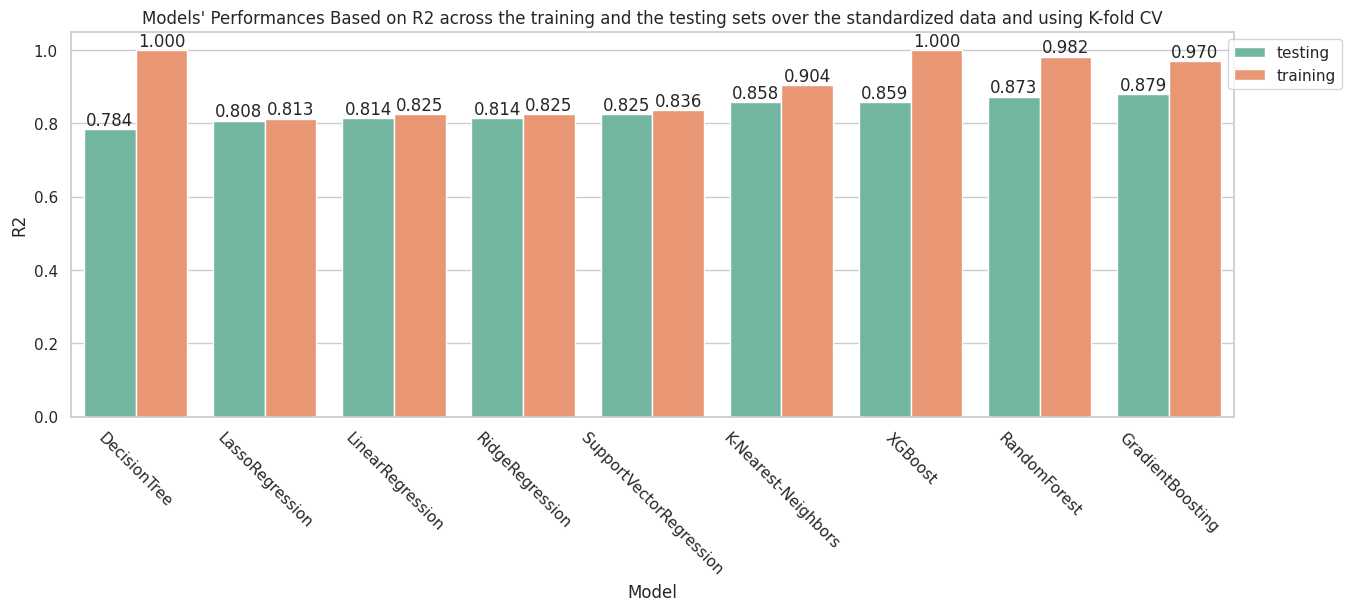

In [112]:
eval_stand_cv.sort_values(['R2', 'set_type'], inplace=True)
plt.figure(figsize=(15,5))
bar=sns.barplot(data=eval_stand_cv, x='Model', y='R2', hue='set_type')
plt.xlabel("Model")
plt.title("Models' Performances Based on R2 across the training and the testing sets over the standardized data and using K-fold CV")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)
plt.xticks(rotation = -45)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

**Observations** : By visually inscpecting the upper plot, it's obvious that several models suffers from the overfitting problem, particularly the Decision Tree and the XGBoost models. Other best performing models like RandomForest and GradientBoosting has also alarming signs of overfitting as the difference between their R2 performances on the training and the testing sets is remarquable. In the next section, we will present a more systematic method to detect the overfit.

#### Visualizing the MAPE-training vs. MAPE-testing of models fitted on standardized data and using cross validation


In [40]:
# Melt the DataFrame to unpivot the MAPE columns
eval_stand_cv = full_evals_cv[full_evals_cv['scaler']=='StandardScaler'].melt(id_vars=['Model'],
                      value_vars=['MAPE-training', 'MAPE-testing'],
                      var_name='set_type',
                      value_name='MAPE')

# Replace 'MAPE-training' and 'MAPE-testing' with 'training' and 'testing' in the 'set_type' column
eval_stand_cv['set_type'] = eval_stand_cv['set_type'].str.replace('MAPE-', '')
eval_stand_cv.head()

,Model,set_type,MAPE
0,LinearRegression,training,0.116081
1,RidgeRegression,training,0.115576
2,LassoRegression,training,0.111185
3,RandomForest,training,0.031152
4,GradientBoosting,training,0.046031


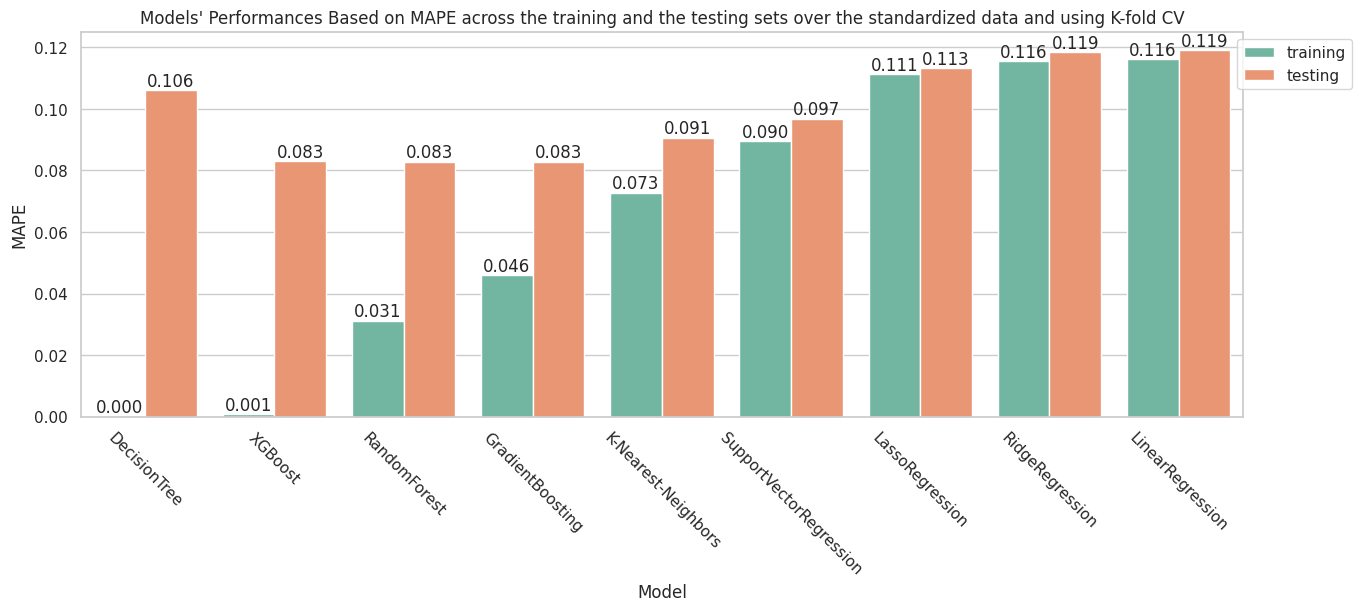

In [51]:
eval_stand_cv.sort_values(['MAPE', 'set_type'], ascending=True, inplace=True)
plt.figure(figsize=(15,5))
bar=sns.barplot(data=eval_stand_cv, x='Model', y='MAPE', hue='set_type')
plt.xlabel("Model")
plt.title("Models' Performances Based on MAPE across the training and the testing sets over the standardized data and using K-fold CV")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)
plt.xticks(rotation = -45)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

### 4.3 Quantifying the overfitting accross the different models

There is no strict threshold that universally defines when the difference is alarming, as it can vary depending on the context, dataset, and specific problem. So, we looked for some best pratices and general guidelines about how to detect the overfitting in a concise manner :

- **Relative Difference**: If the testing performance is significantly lower than the training performance by a substantial margin (e.g., more than 10-15% relative difference in error metrics), this might be alarming.
- **Absolute Difference**: An absolute difference in performance metrics, such as R² decreasing by more than 0.1 or MSE increasing by more than a certain threshold, can also indicate overfitting.

In our study, we will use the relative difference as base method to inspect the overfitting. We will be using the following rules to evaluate our trained models according to the overfitting problem :

1. **Compute Relative Difference**: We will calculate the relative difference between the training and testing R² values. This is done using the formula: (r2_training - r2_testing) / abs(r2_training). This computes the relative difference as a proportion of the training R².

2. **Interpreting the Overfitting**: our interpretation is based on a fixed threshold. If the relative difference exceeds or equals to 10%, the model is considered overfitting.

In [42]:
full_evals_cv['r2_relative_difference']= full_evals_cv.apply(lambda x: round((abs(x['R2-training'] - x['R2-testing']) / x['R2-training']),2 ) if x['R2-training'] > 0 else None, axis=1)
full_evals_cv['overfitting'] = (full_evals_cv['r2_relative_difference']>= 0.1) & (pd.notna(full_evals_cv['r2_relative_difference']) )
full_evals_cv[['Model', 'R2-training', 'R2-testing', 'scaler', 'r2_relative_difference', 'overfitting' ]]

,Model,R2-training,R2-testing,scaler,r2_relative_difference,overfitting
0,LinearRegression,0.825410,0.813990,StandardScaler,0.01,False
1,RidgeRegression,0.825324,0.814328,StandardScaler,0.01,False
2,LassoRegression,0.812555,0.807792,StandardScaler,0.01,False
3,RandomForest,0.981527,0.872829,StandardScaler,0.11,True
4,GradientBoosting,0.970379,0.879066,StandardScaler,0.09,False
5,SupportVectorRegression,0.835740,0.825400,StandardScaler,0.01,False
6,K-Nearest-Neighbors,0.904384,0.858008,StandardScaler,0.05,False
7,DecisionTree,1.000000,0.784153,StandardScaler,0.22,True
8,XGBoost,0.999988,0.858600,StandardScaler,0.14,True
9,LinearRegression,0.865409,0.852590,Normalizer,0.01,False


In the following plot we will visualize the relative difference between the training and testing R2 and across scaling methods. We will highlight the cases of overfitting using the orange color. As we have explained above, when the relative difference exceeds our treshold (0.1) then, we consider that the model has an overfitting issue.

<Figure size 2000x500 with 0 Axes>

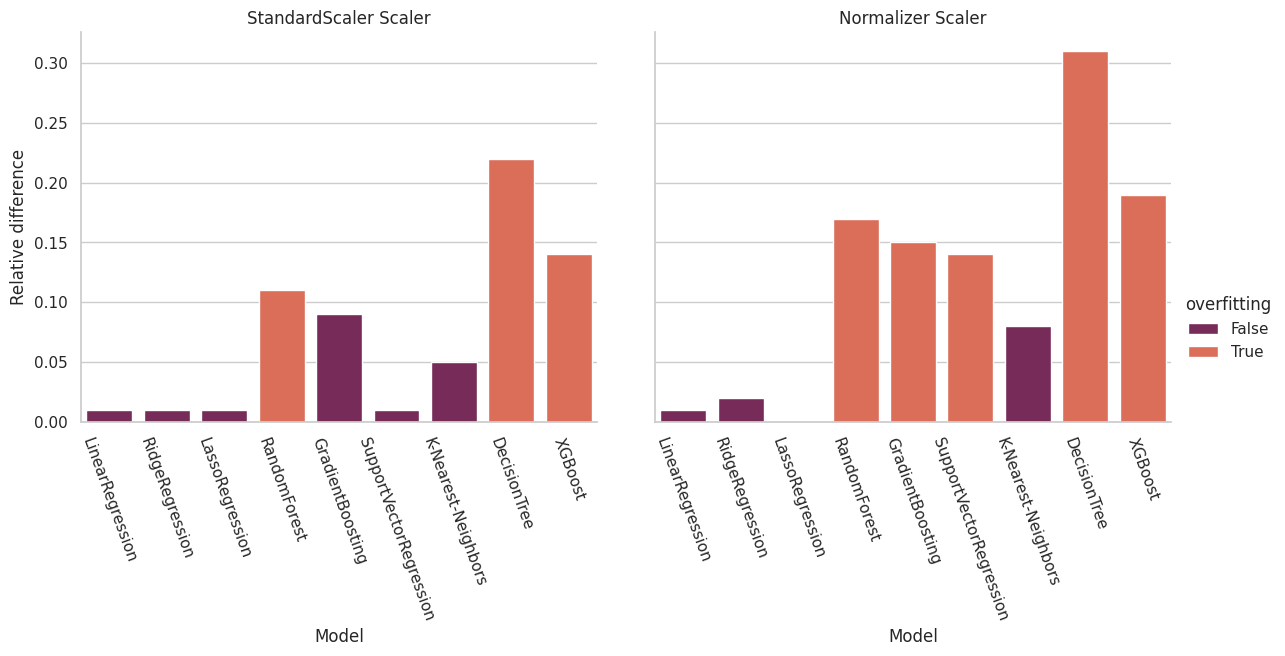

In [49]:
# Catplot
plt.figure(figsize=(20,5))
g = sns.catplot(x="Model", y="r2_relative_difference", hue="overfitting", col="scaler", kind="bar", data=full_evals_cv, height=5, aspect=1.2, palette="rocket")
g.set_axis_labels("Model", "Relative difference")
g.set_titles(col_template="{col_name} Scaler")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-70)
plt.show()

### 4.4 Conclusions

Based on the evaluation results obtained using K-fold cross-validation and the inspection for overfitting, we can draw several important conclusions and recommendations for selecting the best model for our regression problem.

#### Key Observations
 1. ** Scaling and overfitting ** :  
    - It can be noticed that most of the trained models fitted on the normalized data showed signs of overfitting with a drop in performances on the testing data and by consequence a relative difference higher than our treshold. All of these models with the exception of Linear Regression and KNN didn't succeed to generalize to unseen data.
    - On the other hand, when using the StandardScaler, the overall performances of most of the models have improved. However, we can notice that the best performing models RandomForest, XGboost and slightly Gradient Boosting that are particularly affected by the overfitting.

2.  **Overfitting Indicators using Standard data:**
    - Models like **RandomForest**, **DecisionTree**, and **XGBoost** show significant differences between their training and testing R² scores, indicating overfitting.
    - The `r2_relative_difference` is notably higher for these models, especially for DecisionTree (0.22) and XGBoost (0.14).

3. **Performance Without Overfitting on Standard data:**
    - Models such as **LinearRegression**, **RidgeRegression**, **LassoRegression**, **SupportVectorRegression**, and **K-Nearest-Neighbors** demonstrate a much smaller gap between training and testing R² scores, indicating better generalization.
    - These models have a `r2_relative_difference` around 0.01 to 0.05, suggesting they are less prone to overfitting.

4. **Top Performing Models:**
    - **GradientBoosting** shows a high R² score on both training (0.970379) and testing (0.879066) data with a relatively low `r2_relative_difference` (0.09), indicating it is both performant and well-generalized.

#### Recommendations

1. **Gradient Boosting:**
    - **GradientBoosting** is the top candidate for your regression problem due to its high testing R² score and low overfitting indication. It balances high performance with good generalization.

2. **RandomForest and XGBoost:**
    - Despite their high training R² scores, the overfitting observed suggests they might not generalize well to unseen data. We will consider using techniques such as:
        - **Hyperparameter Tuning:** Adjusting parameters like `n_estimators`, `max_depth`, `min_samples_split`, etc.
        - **Regularization:** Increase regularization parameters to reduce overfitting.
        - **Feature Engineering:** Include or exclude features based on their importance and correlation.

3. **DecisionTree:**
    - DecisionTree shows severe overfitting (R²-training = 1.000, R²-testing = 0.784153). This model might not be suitable unless combined into an ensemble method like RandomForest or GradientBoosting.

4. **SupportVectorRegression and K-Nearest-Neighbors:**
    - These models show balanced performance with relatively low overfitting indicators. They could serve as good alternatives or be included in an ensemble approach.

5. **Linear Models (LinearRegression, RidgeRegression, LassoRegression):**
    - These models perform consistently well with minimal overfitting. They are simpler and could serve as robust baselines or in combination with other models in an ensemble method.

### Action Plan

1. **Fine-Tune Top Models:**
    - Perform hyperparameter tuning on **GradientBoosting**, **RandomForest**, and **XGBoost** to reduce overfitting and improve performance.
    - Use techniques such as GridSearchCV or RandomizedSearchCV with early stopping for models that support it.

2. **Evaluate Ensembles:**
    - Consider building ensemble models (e.g., Stacking, Bagging, or Boosting) that combine the strengths of multiple models to improve robustness and performance.

**Summary**

- The results of our different experimentations suggest that while scaling techniques improve model performance by aiding in convergence and optimization, they also exacerbate overfitting in more complex models.

- Overfitting is particularly severe in complex, high-capacity models like XGBoost, RandomForest, and GradientBoosting. This can be explained by the fact that these models are highly flexible and capable of capturing complex patterns in the data. When the data is scaled using the StandardScaler, it often enhances the performance by improving convergence and optimization. However, this also makes these models more susceptible to overfitting, as they can fit noise and minor fluctuations in the training data too closely. Consequently, while the models achieve high performance on the training data, their ability to generalize to new, unseen data is compromised, leading to overfitting. Other techniques such as regularization, pruning and hyperparameter tuning may be necessary to ensure robust and generalizable model performance.
-  Finally, simpler models such as Linear Regression, Lasso Regression, and Ridge Regression are less prone to overfitting when associate to the suitable scaling method. They represent a good alternative to our regression problem since they offer a balance of simplicity and performance. Yet, they may require different optimization approaches to enhance their predictive capabilities without compromising generalizability.


# Task 5: Hyperparameters tuning and comparaison of Top models

We will carry on our experimentation using StandarScaler as our base data scaling method. We will be finetuning the hyperparameters of the following regressors : **XGboost, RandomForest, Gradient Boosting**. Our focus on hyperparameters that enhance the model performances while reducing its overfitting issue. We will use GridSearchCV which combines the hyperparameter search operations and cross-validation operations to ensure the model's performance is consistent across different subsets of the data.

* **Gradient Boosting Hyperparameters**

  - **n_estimators (100) and learning_rate (0.1)**: The n_estimators parameter controls the number of boosting stages, while the learning_rate shrinks the contribution of each tree. There is a trade-off between these two: decreasing learning_rate requires more trees (n_estimators) to maintain performance, potentially increasing computational cost.

  - **max_depth (3), min_samples_split (2), and min_samples_leaf (1)**: These parameters control the complexity of each individual tree. Reducing max_depth and increasing min_samples_split or min_samples_leaf can reduce overfitting.

  - **subsample (1.0)**: Using a fraction less than 1.0 introduces randomness into the model, which can reduce overfitting and improve generalization.



### 5.1 Tuning the models using GridSearchCV

In [45]:
# Define models with hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [2, 3, 5] ,
            'subsample': [0.5, 0.75, 1.0],
            'min_samples_split': [2, 3, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [2, 3, 5],
            'reg_alpha': [0, 0.01, 0.1], #L2 regularization term in XGBoost, it helps to prevent overfitting by penalizing large coefficients in the model.
            'reg_lambda': [1.0, 1.5, 2.0], #L1 regularization term in XGBoost, it helps to prevent overfitting by adding a penalty for large coefficients in the model.4
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.6, 0.8],
            'gamma': [0, 0.1, 0.2]
        }
    }
}

#The scoring metrics for GridSearch and Cross Validation
scoring = {
    'R2': 'r2',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

def performing_gridSearch_evaluating_best_model(model, params, X, y, scoring, cv=3) :
  # Perform grid search
  grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, refit='R2', cv=cv, n_jobs=-1, verbose=2)
  grid_search.fit(X, y)

  # Evaluate the model with the best parameters using cross validation
  train_metrics, test_metrics = cross_val_evaluate_model(grid_search.best_estimator_, X_sc, y, scoring, cv=cv)
  return {
      'best_params' : grid_search.best_params_ ,
      'best_score' : grid_search.best_score_,
      'cv_train_metrics' : train_metrics,
      'cv_test_metrics' : test_metrics,
  }


# Collect results
results = []

#Scaling the data
sc= StandardScaler()
X_sc = sc.fit_transform(X)
kf= KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model_info in models.items():
  print(model_name)
  model = model_info['model']
  param_grid = model_info['params']
  # Evaluate model
  metrics = performing_gridSearch_evaluating_best_model(model, param_grid, X_sc, y, scoring, kf )
  #recod the results
  results.append( {
          'Model': model_name,
          'R2-training': metrics['cv_train_metrics']['R2'],
          'R2-testing': metrics['cv_test_metrics']['R2'],
          'MAPE-training': -metrics['cv_train_metrics']['MAPE'],
          'MAPE-testing': -metrics['cv_test_metrics']['MAPE'],
          'best_params': metrics['best_params']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df


RandomForest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
GradientBoosting
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
XGBoost
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


,Model,R2-training,R2-testing,MAPE-training,MAPE-testing,best_params
0,RandomForest,0.981212,0.875269,0.032342,0.082045,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,GradientBoosting,0.979970,0.888001,0.040308,0.080904,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s..."
2,XGBoost,0.966569,0.885942,0.048693,0.082902,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn..."


In [52]:
for i in range(results_df.shape[0]): print(results_df['best_params'][i])

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}


In [92]:
results_df.drop('overfitting', inplace=True, axis=1)

In [93]:
#Adding the relative difference and the overfitting flag to the hyperparameter tuning results
results_df['r2_relative_difference']= results_df.apply(lambda x: round((abs(x['R2-training'] - x['R2-testing']) / x['R2-training']),2 ) if x['R2-training'] > 0 else None, axis=1)
results_df['mape_relative_difference']= results_df.apply(lambda x: round((abs(x['MAPE-training'] - x['MAPE-testing']) / x['MAPE-training']),2 ) if x['MAPE-training'] > 0 else None, axis=1)
#Adding a flag to indicate the experiment set
results_df['params'] = ['tuned']*3
results_df

,Model,R2-training,R2-testing,MAPE-training,MAPE-testing,best_params,r2_relative_difference,params,mape_relative_difference
0,RandomForest,0.981212,0.875269,0.032342,0.082045,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.11,tuned,1.54
1,GradientBoosting,0.979970,0.888001,0.040308,0.080904,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",0.09,tuned,1.01
2,XGBoost,0.966569,0.885942,0.048693,0.082902,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",0.08,tuned,0.70


In [88]:
#Getting the Original Results before the hyperparameter tuning
org_results=full_evals_cv.query("Model in ['RandomForest', 'GradientBoosting', 'XGBoost'] and scaler =='StandardScaler' ")
org_results['mape_relative_difference']= org_results.apply(lambda x: round((abs(x['MAPE-training'] - x['MAPE-testing']) / x['MAPE-training']),2 ) if x['MAPE-training'] > 0 else None, axis=1)
org_results['params'] = ['default'] *3
org_results

,Model,R2-training,R2-testing,MAPE-training,MAPE-testing,scaler,r2_relative_difference,overfitting,mape_relative_difference,params
3,RandomForest,0.981527,0.872829,0.031152,0.082909,StandardScaler,0.11,True,1.66,default
4,GradientBoosting,0.970379,0.879066,0.046031,0.082910,StandardScaler,0.09,False,0.80,default
8,XGBoost,0.999988,0.858600,0.000875,0.083035,StandardScaler,0.14,True,93.94,default


In [94]:
#Combining the results for plotting purpose
combined = pd.concat([org_results.drop(['scaler', 'overfitting'], axis=1),results_df.drop('best_params', axis=1)])
combined

,Model,R2-training,R2-testing,MAPE-training,MAPE-testing,r2_relative_difference,mape_relative_difference,params
3,RandomForest,0.981527,0.872829,0.031152,0.082909,0.11,1.66,default
4,GradientBoosting,0.970379,0.879066,0.046031,0.082910,0.09,0.80,default
8,XGBoost,0.999988,0.858600,0.000875,0.083035,0.14,93.94,default
0,RandomForest,0.981212,0.875269,0.032342,0.082045,0.11,1.54,tuned
1,GradientBoosting,0.979970,0.888001,0.040308,0.080904,0.09,1.01,tuned
2,XGBoost,0.966569,0.885942,0.048693,0.082902,0.08,0.70,tuned


### 5.1 Plotting the results and analysing the overfitting after tuning

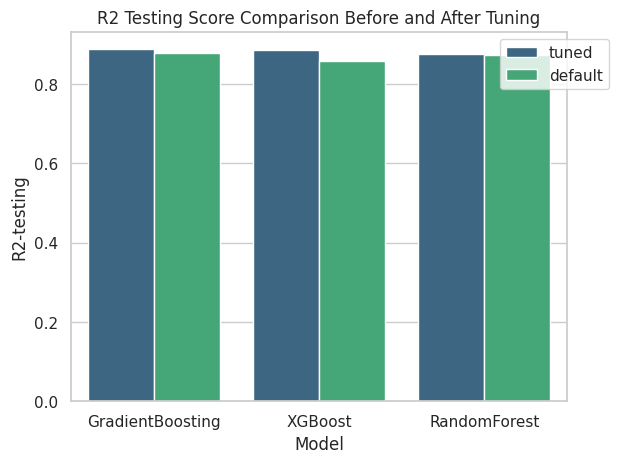

In [80]:
#Plotting the results
#Plot and comparing R2 Scores on testing data after hyperparameter tuning
combined.sort_values('R2-testing', ascending=False, inplace=True) #Higher is better
sns.barplot(data=combined, x='Model', y='R2-testing', hue='params', palette="viridis")
plt.title('R2 Testing Score Comparison Before and After Tuning')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show() ;


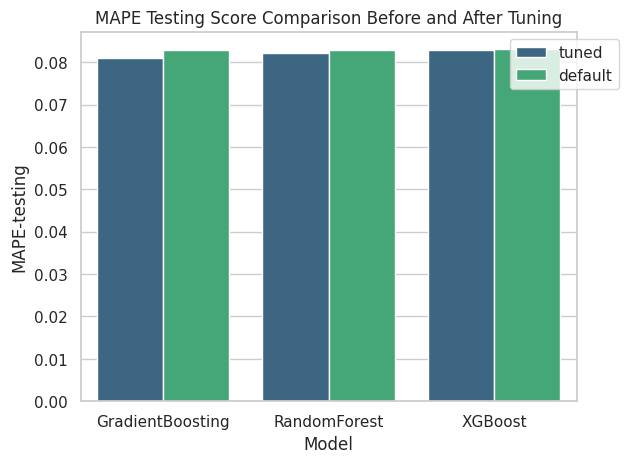

In [79]:
#Plot and comparing MAPE Scores on testing data after hyperparameter tuning
combined.sort_values('MAPE-testing', inplace=True) #Lower is better
sns.barplot(data=combined, x='Model', y='MAPE-testing', hue='params', palette="viridis")
plt.title('MAPE Testing Score Comparison Before and After Tuning')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show() ;

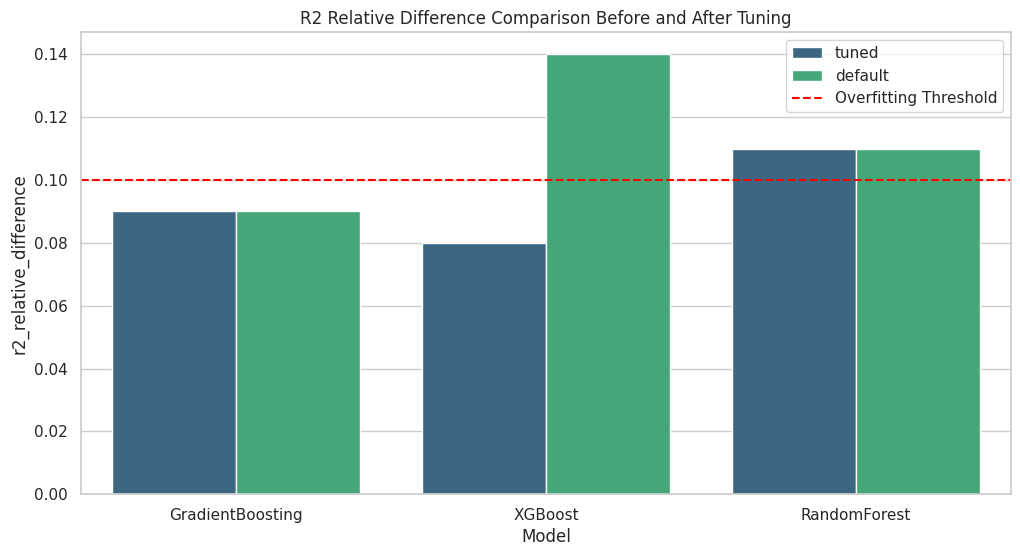

In [113]:
#Overfitting visualization
# Plot R2 Relative Difference
plt.figure(figsize=(12, 6))
combined.sort_values('R2-testing', ascending=False, inplace=True) #Higher is better
sns.barplot(data=combined, x='Model', y='r2_relative_difference', hue='params', palette="viridis")
plt.axhline(0.1, color='red', linestyle='--', label='Overfitting Threshold')
plt.title('R2 Relative Difference Comparison Before and After Tuning')
plt.legend()
plt.show()

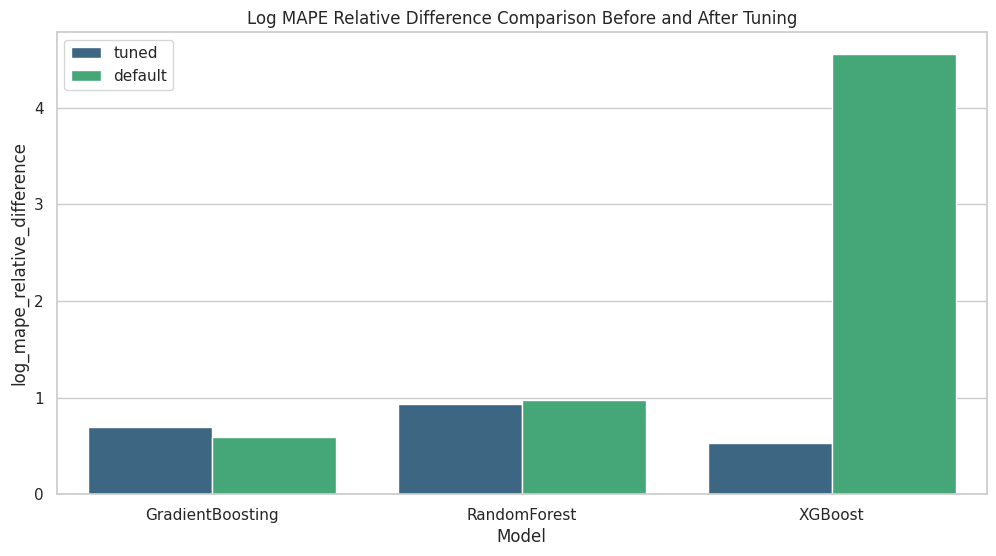

In [114]:
# Plot MAPE Relative Difference
plt.figure(figsize=(12, 6))
combined.sort_values('MAPE-testing', ascending=True, inplace=True) #Higher is better
# We apply log transformation to mape_relative_difference since there is an extreme value '93%' (RandomForest , default params)
combined['log_mape_relative_difference'] = np.log1p(combined['mape_relative_difference'])
sns.barplot(data=combined, x='Model', y='log_mape_relative_difference', hue='params', palette="viridis")
plt.title('Log MAPE Relative Difference Comparison Before and After Tuning')
plt.legend()
plt.show()

### 5.3 Conclusions

* **Performance Improvement:**
 - RandomForest: Slight improvement in R2 testing score after tuning, indicating slightly better generalization. MAPE testing slightly improved as well.
 - GradientBoosting: Noticeable improvement in both R2 testing and MAPE testing scores after tuning, suggesting better performance and generalization.
 - XGBoost: Significant improvement in R2 testing score and MAPE testing score after tuning, indicating much better performance and reduced overfitting.

* **Overfitting Analysis:**
 - RandomForest: Despite tuning, RandomForest still shows signs of overfitting (high R2 relative difference).
 - GradientBoosting: No significant overfitting observed before and after tuning, with improved performance.
 - XGBoost: Tuning significantly reduced overfitting (lower R2 relative difference), showing better balance between training and testing performance.

* **Recommendation:**
 - GradientBoosting and XGBoost are the most promising models after hyperparameter tuning due to their improved performance and reduced overfitting.
 - RandomForest shows improvement but still has some overfitting issues that need further investigation.

# Task 6 : Saving the final model


In [132]:
#saving the results of all the models evaluations using cross-validation
full_evals_cv_file = "AutoMPG_all_evals_cv_file.csv"
full_evals_cv.to_csv(full_evals_cv_file)

#saving the results of the best models hyperparameters tuning
tuning_results_file="AutoMPG_tuned_best_models_results.csv"
results_df.to_csv(tuning_results_file)

Following the previous recommendations, we will save the Gradient Boosting Model that we have tuned in previous steps.

In [128]:
# Get the params
best_params = results_df[results_df['Model']=='GradientBoosting']['best_params'].values[0]
best_params

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'subsample': 0.5}

In [129]:
#Retrain the model with full dataset and the best params
best_model = GradientBoostingRegressor(**best_params, random_state=42)
best_model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42,
                          subsample=0.5)

In [130]:
# Save the best model to a file
joblib_file = "best_gradient_boosting_model.pkl"
joblib.dump(best_model, joblib_file)

['best_gradient_boosting_model.pkl']

#### Loading the model

In [131]:
# Load the model from the file
loaded_model = joblib.load(joblib_file)

# Use the loaded model to make predictions
predictions = loaded_model.predict(X)  # or X_new for new data

# Print predictions or evaluate the model
print(predictions)

[25.28165286 21.51056256 35.53632963 25.85283791 26.85988518 27.42514115
 12.9713198  26.97124403 19.27263232 28.3018582  14.29958839 20.44657706
 16.39324338 27.47089292 17.71447734 29.06104626 19.4055896  31.8073706
 28.56480018 32.91141407 20.41491394 42.94913428 34.64855797 16.11422603
 27.46220661 25.17301434 19.95297493 17.73982192 25.99654714 23.00994879
 14.40658305 20.34959347 20.00440652 29.88644043 13.44847617 36.47979225
 13.6873606  26.54159945 13.95450785 10.84340971 13.84907437 26.49981842
 35.03192574 26.5181597  14.09406552 12.23717616 17.57326401 36.09032053
 20.68831716 28.45052482 13.80562924 24.57640425 25.13527693 35.37973789
 23.7086054  16.37009255 19.19275156 19.8877924  24.76403142 25.44049624
 12.27073443 20.44196695 26.21330011 22.28930208 24.6725244  26.42561481
 24.55195519 28.81106749 19.09422551 13.88809379 21.3789441  13.45613051
 22.11583102 19.17237547 20.19707086 26.93558542 14.18387962 16.11504862
 27.29629172 18.60397238 24.5729046  19.84196109 13.